# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
df=pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# - Q1. Do smokers have higher insurance charges than non-smokers?


1. State your Null Hypothesis and Alternative Hypothesis

    Null Hypothesis:

    There is no significant difference in insurance charges between smokers and non-smokers.

    Alternative Hypothesis:
    
    There is a significant difference in the insurance charges between smokers and non-smokers
    
    
2. Select the correct test according to the data type and number of samples

    2 Sample T-test
  
  
  
3. Test the assumptions of your selected test.


In [3]:
# Creating smoker/non-smoker filters for tests
smokers=df.loc[df['smoker']=='yes'].copy()
non_smokers=df.loc[df['smoker']=='no'].copy()
# finding charges in groups
smoker_charges=smokers['charges']
non_smoker_charges=non_smokers['charges']

## Testing for Outliers

In [4]:
# checking smoker group
smoker_zscore=stats.zscore(smoker_charges)
smoker_outliers=abs(smoker_zscore)>3
np.sum(smoker_outliers)

0

In [5]:
# checking non-smoker group
non_smoker_zscore=stats.zscore(non_smoker_charges)
non_smoker_outliers=abs(non_smoker_zscore)>3
np.sum(non_smoker_outliers)

24

In [6]:
# Removing outliers using loop
while np.sum(non_smoker_outliers)>0 and len(non_smoker_outliers)>0:
    non_smoker_charges=non_smoker_charges[(np.abs(stats.zscore(non_smoker_charges))<3)]
    non_smoker_zscore=stats.zscore(non_smoker_charges)
    non_smoker_outliers=abs(non_smoker_zscore)>3
    np.sum(non_smoker_outliers)

In [7]:
# rechecking non-smoker group
non_smoker_zscore=stats.zscore(non_smoker_charges)
non_smoker_outliers=abs(non_smoker_zscore)>3
np.sum(non_smoker_outliers)

0

## Testing Assumption of Normality

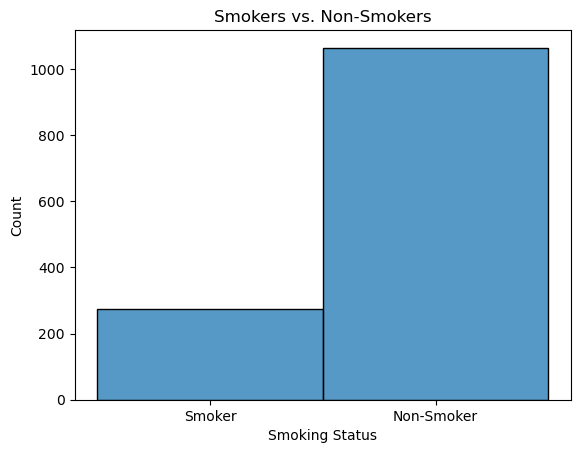

no     1064
yes     274
Name: smoker, dtype: int64

In [8]:
sns.histplot(df['smoker'])
plt.title('Smokers vs. Non-Smokers')
plt.xlabel('Smoking Status')
plt.xticks(ticks=range(0,2),labels=['Smoker','Non-Smoker'])
plt.show();
df['smoker'].value_counts()

We have more than 15 samples in each group. The normality test is unnecessary. 

## Testing Assumption of Equal Variance

In [9]:
# Performing Levene's test
stats.levene(smoker_charges, non_smoker_charges)

LeveneResult(statistic=791.4740947105306, pvalue=7.254211040409339e-136)

Since we have unequal variances between groups we will include `equal_var=False` during our t-test.

## Performing Independent T-test

In [11]:
stats.ttest_ind(smoker_charges,non_smoker_charges,equal_var=False)

Ttest_indResult(statistic=34.76759075466699, pvalue=5.672680697343108e-106)

We have a p-value less than our significance level, thus we reject the null hypothesis.
There is a significant difference in the insurance charges between smokers and non-smokers.


## Visualization

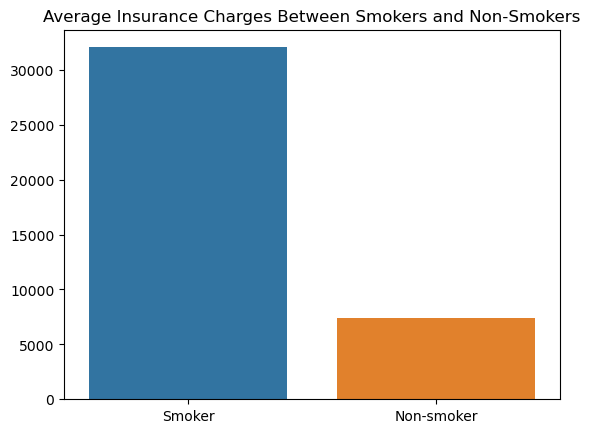

In [15]:
sns.barplot(x=['Smoker','Non-smoker'],y=[smoker_charges.mean(),non_smoker_charges.mean()])
plt.title('Average Insurance Charges Between Smokers and Non-Smokers');

There is a significant difference in the insurance charges between smokers and non-smokers.

# - Q2. Are men more likely to smoke than women?


1. State your Null Hypothesis and Alternative Hypothesis

    Null Hypothesis:

    There is no signficant difference in between the amount of male smokers and the amount of female smokers.

    Alternative Hypothesis:
    
    There is a signficant difference in between the amount of male smokers and the amount of female smokers.    
    
    
2. Select the correct test according to the data type and number of samples

      Chi-Square Test


## Evaluating Samples with Contingency Table

In [29]:
table=pd.crosstab(df['sex'],df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


## Assumptions
Our groups only contain categorical nominal values.
Our outcomes are independent.
All assumptions are met.

## Performing Chi-Squared Test

In [52]:
# Running test and saving outputs
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result 
print(p)
# is pvalue less than .05?
p<.05

0.006548143503580696


True

We have a significant result. We reject the null hypothesis.

There is a signficant difference in between the amount of male smokers and the amount of female smokers.  

## Visualizing smokers by sex


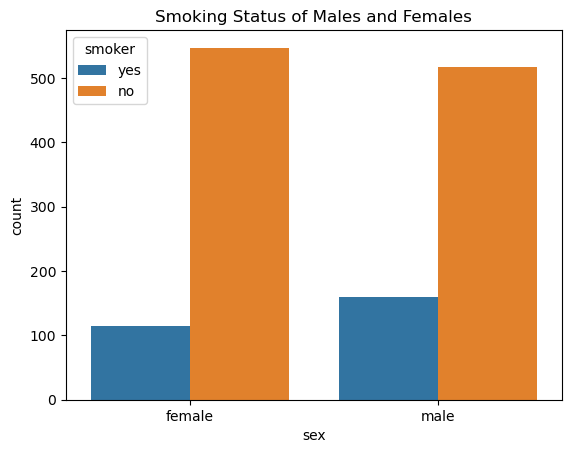

In [26]:
ax=sns.countplot(x=df['sex'],hue=df['smoker'])
plt.title('Smoking Status of Males and Females')
plt.show();

# - Q3. Do different regions have different charges, on average?



1. State your Null Hypothesis and Alternative Hypothesis

    Null Hypothesis:

    There is no significant difference in insurance charges between different regions, on average.

    Alternative Hypothesis:
    
    There is a significant difference in insurance charges between different regions, on average.
    
    
2. Select the correct test according to the data type and number of samples

    ANOVA
  

## Separating Groups

In [56]:
## Create groups dictionary. There are only 3 groups, but this is even more helpful when there are many groups
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

## Testing Assumption of Normality

In [58]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
# converting to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
# adding sig level to df
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


Groups are not normal but n is large enough to continue with tests.

## Testing Assumption of Equal Variance


In [59]:
# With the Levene's test
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

We did not meet the assumption of equal variance, so we will need to perform a Kruskal-Wallis test.

In [60]:
stats.kruskal(*groups.values())


KruskalResult(statistic=4.734181215658743, pvalue=0.19232908072121002)

Since our p-value is greater than 0.05, we fail to reject the null hypothesis.

There is a significant difference in insurance charges between different regions, on average.


## Visualization 

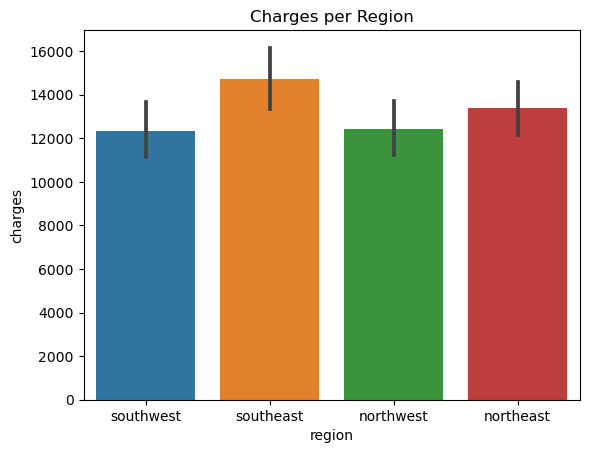

In [62]:
# Visualizing charges per region
sns.barplot(x=df['region'],y=df['charges'])
plt.title('Charges per Region');